In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [2]:
from load_data import load_data,class_breakdown

In [3]:
data_name ="EEG"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data EEG
batch size:16
train data (9958, 117, 14),(9958, 1)
test data (4905, 117, 14),(4905, 1)


In [4]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=5466, percentage=54.891
Class=2, total=4492, percentage=45.109
Class=1, total=2675, percentage=54.536
Class=2, total=2230, percentage=45.464


In [5]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (9958, 2)
y test shape: (4905, 2)


## 데이터 정규화

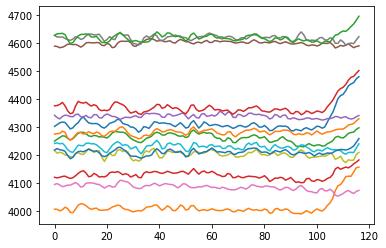

In [6]:
plt.plot(trainx[0])

In [7]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

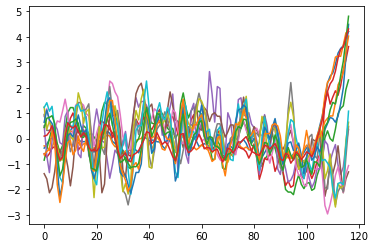

In [8]:
plt.plot(trainx[0])

In [9]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(9958, 1, 117, 14)
trainY shape:(9958, 2)
validX shape:(2452, 1, 117, 14)
validY shape:(2452, 2)
testX shape:(2453, 1, 117, 14)
testY shape:(2453, 2)


In [10]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 117
input_channel 14


# 2. Training condition 정의

In [11]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-5

In [12]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [13]:
from FCN import CNN_MC_dropout

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3

In [14]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

2


In [15]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [16]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 117, 14), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 117, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 117, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 117, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128), dtype=fl

# 4. Training

In [17]:
import time
import os

In [18]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_MCdropout_standardized_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

EEG_CNN_MCdropout_standardized_1e-05_16


In [19]:
from training import get_batch

In [20]:
keep_prob =1.0

In [23]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/1.ckpt
  training loss:	0.690036
  training acc:	0.542
  validation loss:	0.689298
  validation acc:	0.538
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/2.ckpt
  training loss:	0.686316
  training acc:	0.549
  validation loss:	0.687541
  validation acc:	0.538
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/3.ckpt
  training loss:	0.683839
  training acc:	0.549
  validation loss:	0.685054
  validation acc:	0.538
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e

Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/27.ckpt
  training loss:	0.510901
  training acc:	0.798
  validation loss:	0.511624
  validation acc:	0.790
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/28.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/28.ckpt
  training loss:	0.502046
  training acc:	0.803
  validation loss:	0.502674
  validation acc:	0.797
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/29.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/29.ckpt
  training loss:	0.493280
  training acc:	0.809
  validation loss:	0.493833
  validation acc:	0.801
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/30.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_stan

  training loss:	0.342154
  training acc:	0.865
  validation loss:	0.343195
  validation acc:	0.862
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/54.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/54.ckpt
  training loss:	0.338138
  training acc:	0.866
  validation loss:	0.339134
  validation acc:	0.863
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/55.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/55.ckpt
  training loss:	0.334244
  training acc:	0.868
  validation loss:	0.335184
  validation acc:	0.866
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/56.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/56.ckpt
  training loss:	0.330460
  training acc:	0.869
  valid

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/80.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/80.ckpt
  training loss:	0.261997
  training acc:	0.900
  validation loss:	0.260018
  validation acc:	0.894
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/81.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/81.ckpt
  training loss:	0.259729
  training acc:	0.900
  validation loss:	0.257598
  validation acc:	0.895
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/82.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/82.ckpt
  training loss:	0.257483
  training acc:	0.902
  validation loss:	0.255207
  validation acc:	0.898
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardi

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/106.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/106.ckpt
  training loss:	0.210908
  training acc:	0.923
  validation loss:	0.206493
  validation acc:	0.921
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/107.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/107.ckpt
  training loss:	0.209208
  training acc:	0.924
  validation loss:	0.204729
  validation acc:	0.922
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/108.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/108.ckpt
  training loss:	0.207522
  training acc:	0.925
  validation loss:	0.202981
  validation acc:	0.924
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/132.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/132.ckpt
  training loss:	0.171810
  training acc:	0.942
  validation loss:	0.166091
  validation acc:	0.946
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/133.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/133.ckpt
  training loss:	0.170478
  training acc:	0.942
  validation loss:	0.164736
  validation acc:	0.947
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/134.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/134.ckpt
  training loss:	0.169156
  training acc:	0.943
  validation loss:	0.163386
  validation acc:	0.948
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/158.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/158.ckpt
  training loss:	0.140374
  training acc:	0.957
  validation loss:	0.134502
  validation acc:	0.959
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/159.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/159.ckpt
  training loss:	0.139298
  training acc:	0.958
  validation loss:	0.133451
  validation acc:	0.960
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/160.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/160.ckpt
  training loss:	0.138234
  training acc:	0.958
  validation loss:	0.132411
  validation acc:	0.961
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/184.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/184.ckpt
  training loss:	0.115156
  training acc:	0.968
  validation loss:	0.110330
  validation acc:	0.969
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/185.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/185.ckpt
  training loss:	0.114288
  training acc:	0.969
  validation loss:	0.109512
  validation acc:	0.969
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/186.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/186.ckpt
  training loss:	0.113424
  training acc:	0.970
  validation loss:	0.108705
  validation acc:	0.969
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/210.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/210.ckpt
  training loss:	0.094193
  training acc:	0.976
  validation loss:	0.091232
  validation acc:	0.976
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/211.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/211.ckpt
  training loss:	0.093454
  training acc:	0.976
  validation loss:	0.090575
  validation acc:	0.976
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/212.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/212.ckpt
  training loss:	0.092721
  training acc:	0.977
  validation loss:	0.089921
  validation acc:	0.976
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/236.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/236.ckpt
  training loss:	0.076840
  training acc:	0.981
  validation loss:	0.075854
  validation acc:	0.982
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/237.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/237.ckpt
  training loss:	0.076241
  training acc:	0.981
  validation loss:	0.075319
  validation acc:	0.982
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/238.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/238.ckpt
  training loss:	0.075646
  training acc:	0.982
  validation loss:	0.074787
  validation acc:	0.982
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/262.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/262.ckpt
  training loss:	0.062625
  training acc:	0.986
  validation loss:	0.063184
  validation acc:	0.987
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/263.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/263.ckpt
  training loss:	0.062139
  training acc:	0.986
  validation loss:	0.062748
  validation acc:	0.987
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/264.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/264.ckpt
  training loss:	0.061659
  training acc:	0.986
  validation loss:	0.062310
  validation acc:	0.987
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/288.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/288.ckpt
  training loss:	0.051260
  training acc:	0.988
  validation loss:	0.052932
  validation acc:	0.988
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/289.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/289.ckpt
  training loss:	0.050871
  training acc:	0.988
  validation loss:	0.052581
  validation acc:	0.988
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/290.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/290.ckpt
  training loss:	0.050487
  training acc:	0.988
  validation loss:	0.052229
  validation acc:	0.988
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/314.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/314.ckpt
  training loss:	0.042227
  training acc:	0.991
  validation loss:	0.044688
  validation acc:	0.990
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/315.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/315.ckpt
  training loss:	0.041920
  training acc:	0.991
  validation loss:	0.044403
  validation acc:	0.991
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/316.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/316.ckpt
  training loss:	0.041615
  training acc:	0.991
  validation loss:	0.044121
  validation acc:	0.991
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/340.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/340.ckpt
  training loss:	0.035011
  training acc:	0.993
  validation loss:	0.038103
  validation acc:	0.992
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/341.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/341.ckpt
  training loss:	0.034764
  training acc:	0.993
  validation loss:	0.037885
  validation acc:	0.992
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/342.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/342.ckpt
  training loss:	0.034518
  training acc:	0.993
  validation loss:	0.037668
  validation acc:	0.992
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/366.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/366.ckpt
  training loss:	0.029242
  training acc:	0.994
  validation loss:	0.032872
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/367.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/367.ckpt
  training loss:	0.029045
  training acc:	0.995
  validation loss:	0.032692
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/368.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/368.ckpt
  training loss:	0.028851
  training acc:	0.995
  validation loss:	0.032519
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/392.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/392.ckpt
  training loss:	0.024680
  training acc:	0.996
  validation loss:	0.028683
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/393.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/393.ckpt
  training loss:	0.024526
  training acc:	0.996
  validation loss:	0.028543
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/394.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/394.ckpt
  training loss:	0.024373
  training acc:	0.996
  validation loss:	0.028403
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/418.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/418.ckpt
  training loss:	0.021107
  training acc:	0.996
  validation loss:	0.025377
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/419.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/419.ckpt
  training loss:	0.020987
  training acc:	0.996
  validation loss:	0.025264
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/420.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/420.ckpt
  training loss:	0.020868
  training acc:	0.997
  validation loss:	0.025152
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/444.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/444.ckpt
  training loss:	0.018324
  training acc:	0.997
  validation loss:	0.022722
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/445.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/445.ckpt
  training loss:	0.018229
  training acc:	0.997
  validation loss:	0.022629
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/446.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/446.ckpt
  training loss:	0.018135
  training acc:	0.997
  validation loss:	0.022536
  validation acc:	0.993
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/470.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/470.ckpt
  training loss:	0.016121
  training acc:	0.997
  validation loss:	0.020559
  validation acc:	0.994
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/471.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/471.ckpt
  training loss:	0.016046
  training acc:	0.997
  validation loss:	0.020485
  validation acc:	0.994
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/472.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/472.ckpt
  training loss:	0.015972
  training acc:	0.997
  validation loss:	0.020411
  validation acc:	0.994
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/496.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/496.ckpt
  training loss:	0.014373
  training acc:	0.998
  validation loss:	0.018726
  validation acc:	0.995
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/497.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/497.ckpt
  training loss:	0.014313
  training acc:	0.998
  validation loss:	0.018665
  validation acc:	0.995
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/498.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/498.ckpt
  training loss:	0.014253
  training acc:	0.998
  validation loss:	0.018602
  validation acc:	0.995
INFO:tensorflow:./model/EEG/EEG_CNN_MCdropout_sta

In [24]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [25]:
from visualization import plot_train_history

In [26]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/loss_graph.png
save ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/acc_graph.png


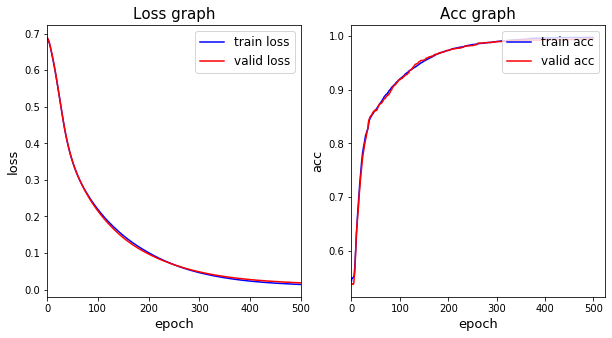

In [27]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [28]:
bestepoch = int(np.argmin(valid_history['loss']))

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [29]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.01848232920595073


In [30]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from ./model/EEG/EEG_CNN_MCdropout_standardized_1e-05_16/499.ckpt
Model restored


### with confusion matrix

In [31]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [32]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

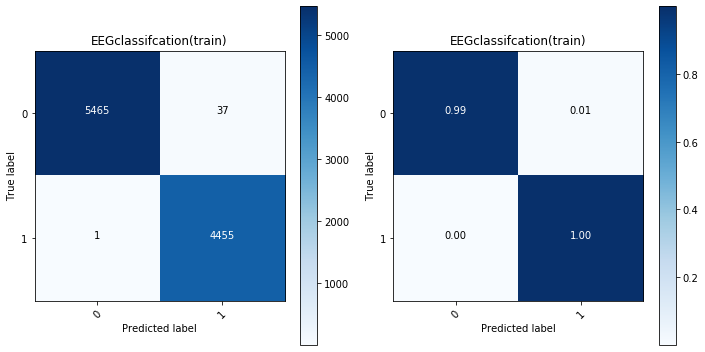

In [33]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

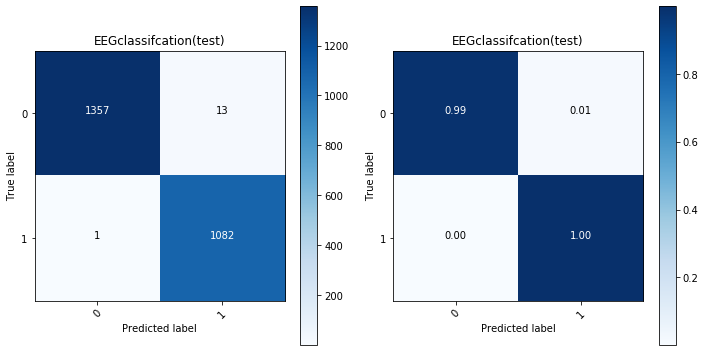

In [34]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# 6. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)
기존논문에서 이미지타겟으로 p(A>T)=0.005 인것과 비교하여, 시계열에서는 조금 더 낮은 threshold가 패턴을 보기에 필요함.
현재 p(A>T) = 0.05로 조정되어있음

In [35]:
import random

In [36]:
last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
print (last_conv_output.shape)
threshold = np.percentile(last_conv_output,99.5)
print ("threshold: {}".format(threshold))

(9958, 117, 128)
threshold: 4.719640171527871


In [37]:
last_conv_bool = last_conv_output>threshold

# 7.Result Visualization
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

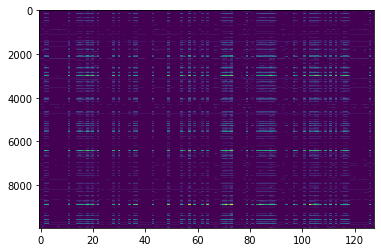

In [38]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

In [39]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

## 패턴의 연속성 pattern candidate 추출(전체길이의 10퍼센트 이상이 highlight 된 부분)
## 현재 서버 메모리때문에 trainX 500개까지만 패턴 클러스터링 적용
### 모든 데이터를 위해서는 수정필요

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [41]:
from itertools import groupby
from operator import itemgetter

In [42]:
consecutive_num =trainX.shape[2]//20
consecutive_num

5

In [43]:
import itertools

In [45]:
input_channel = 3
consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500,:,:,[input_channel]]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":g, "pattern":data[0,g,c], "pattern_channel":output_channel_idx})   

## clustering with different length scale

In [46]:
from tslearn.utils import to_time_series_dataset

In [47]:
X =to_time_series_dataset([list(x['pattern']) for x in consecutive_pattern])
from tslearn.clustering import GlobalAlignmentKernelKMeans
gak_km = GlobalAlignmentKernelKMeans(n_clusters=6)
gak_km_predict = gak_km.fit_predict(X)

In [48]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

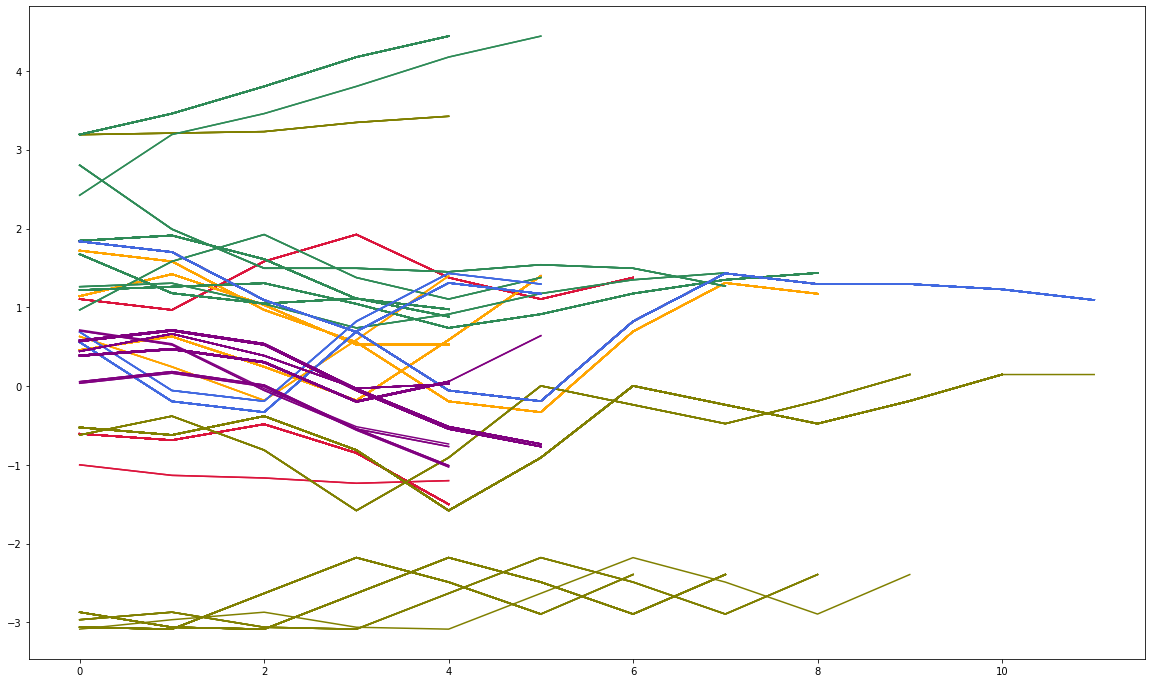

In [49]:
for class_num in range(6):
    a =[i for i,x in enumerate(gak_km_predict) if x ==class_num]
    b=[X[x] for x in a]
    for p in b:
        plt.plot(range(len(p)),p,color = color[class_num])

In [50]:
class_breakdown(gak_km_predict)

Class=1, total=81, percentage=12.960
Class=2, total=125, percentage=20.000
Class=3, total=96, percentage=15.360
Class=4, total=147, percentage=23.520
Class=5, total=60, percentage=9.600
Class=6, total=116, percentage=18.560


f = open('file.txt', 'a+t')
for i,x in enumerate(X):
    for x_ in x:
        f.write(str(x_[0])+",")
    f.write(":"+str(gak_km_predict[i])+"\n")

f.close()      

In [51]:
X_df = pd.DataFrame(columns=["dim_0"],index=range(len(X)))
for i,x in enumerate(X):
    X_df.iloc[i,0] = x

In [52]:
Y_df =gak_km_predict.astype('<U1')

In [53]:
from sktime.transformers.shapelets import ContractedShapeletTransform
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially; once time is up, no further shapelets will be assessed
time_limit_in_mins = 1

# The initial number of shapelet candidates to assess per training series. If all series are visited
# and time remains on the contract then another pass of the data will occur
initial_num_shapelets_per_case = 5

# Whether or not to print on-going information about shapelet extraction. Useful for demo/debugging
verbose = 2

st = ContractedShapeletTransform(
    time_limit_in_mins=time_limit_in_mins,
    num_candidates_to_sample_per_case=initial_num_shapelets_per_case,
    verbose=verbose)
st.fit(X_df, Y_df)

case ids by class {'0': array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63, 147, 153, 156, 165, 167, 170, 177, 180, 191, 193,
       199, 201, 208, 210, 213, 215, 218, 219, 487, 489, 491, 492, 494,
       498, 500, 503, 508, 509, 511, 519, 523, 526, 529, 532, 535, 536,
       539, 542, 543]), '1': array([143, 146, 152, 155, 157, 159, 161, 162, 163, 164, 166, 169, 173,
       175, 176, 178, 179, 181, 184, 186, 189, 190, 192, 198, 200, 202,
       203, 204, 207, 209, 212, 214, 217, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 408, 409, 410, 411, 412, 413,
       414,

Series ID: 562, start_pos: 5, length: 3, info_gain: 0.10167688716749379, 


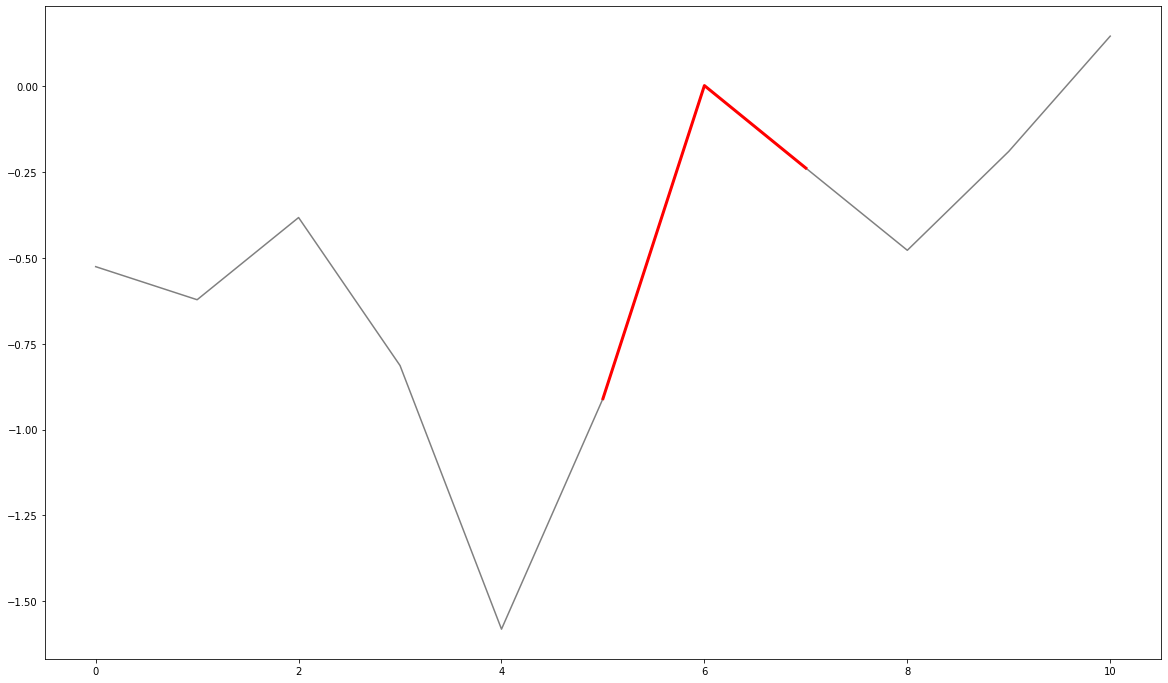

Series ID: 507, start_pos: 2, length: 7, info_gain: 0.08104318833130097, 


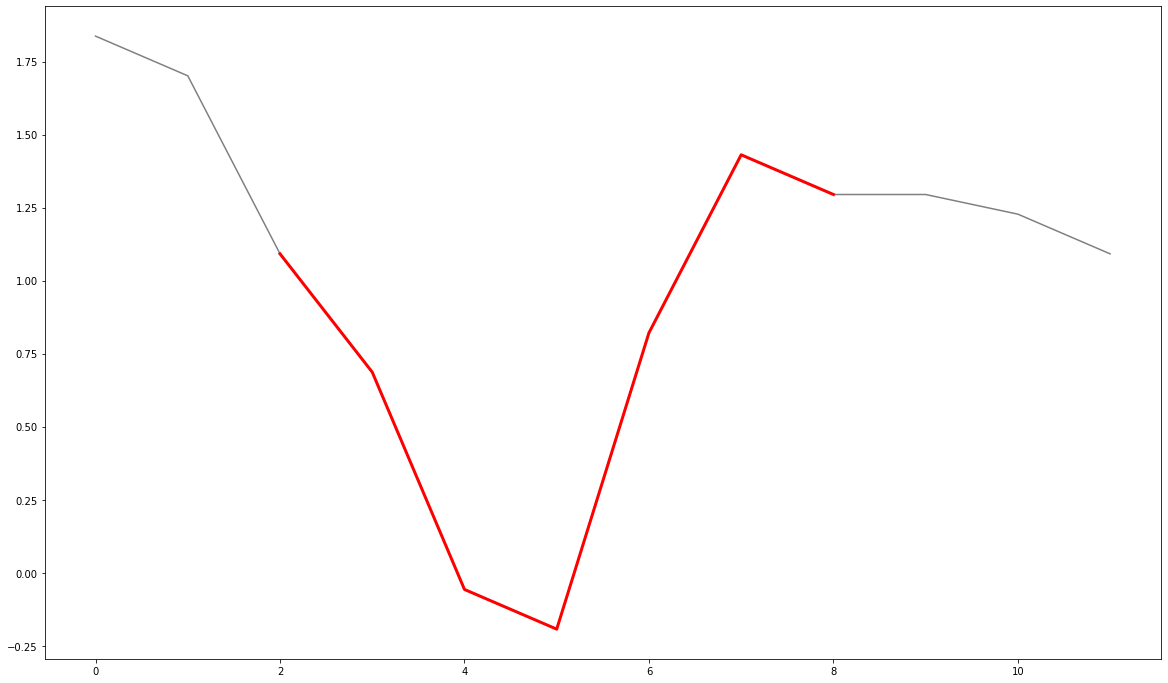

Series ID: 136, start_pos: 2, length: 3, info_gain: 0.08067620756869309, 


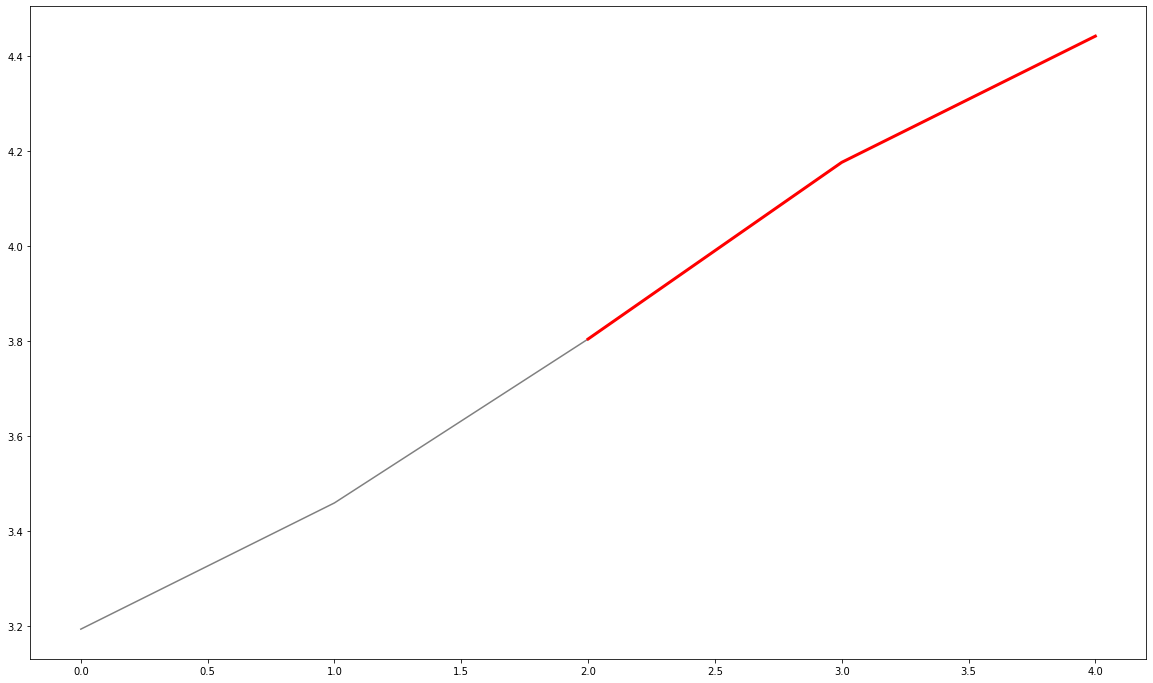

Series ID: 526, start_pos: 7, length: 4, info_gain: 0.06110722221347098, 


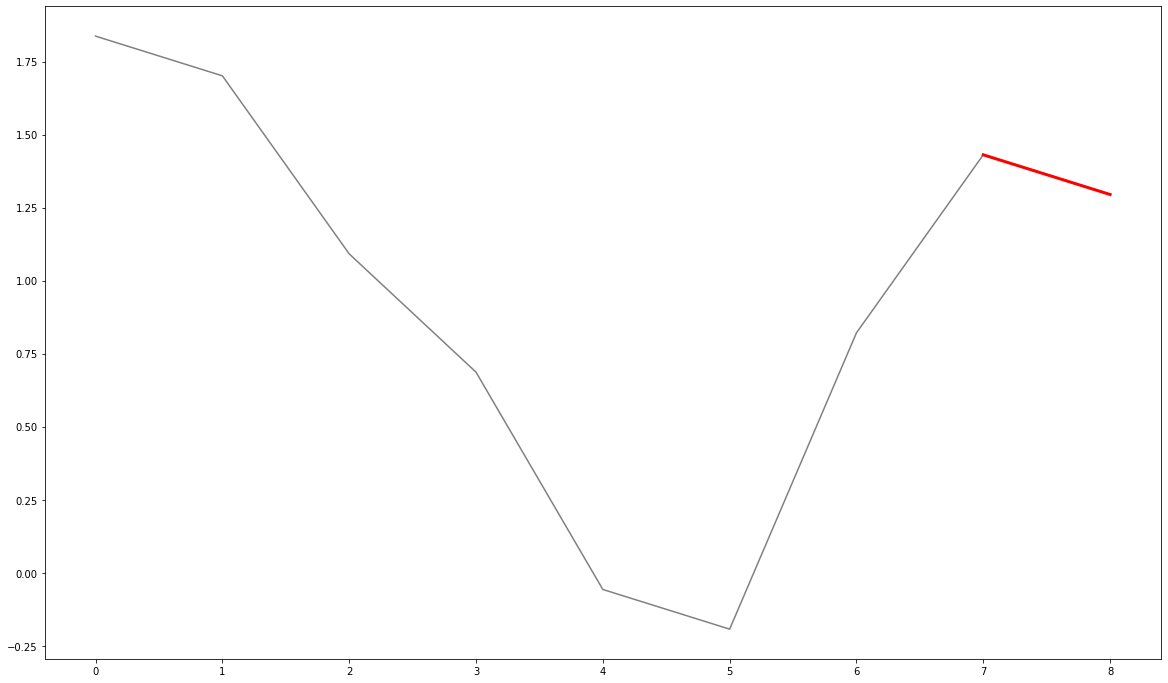

Series ID: 526, start_pos: 2, length: 3, info_gain: 0.06110722221347098, 


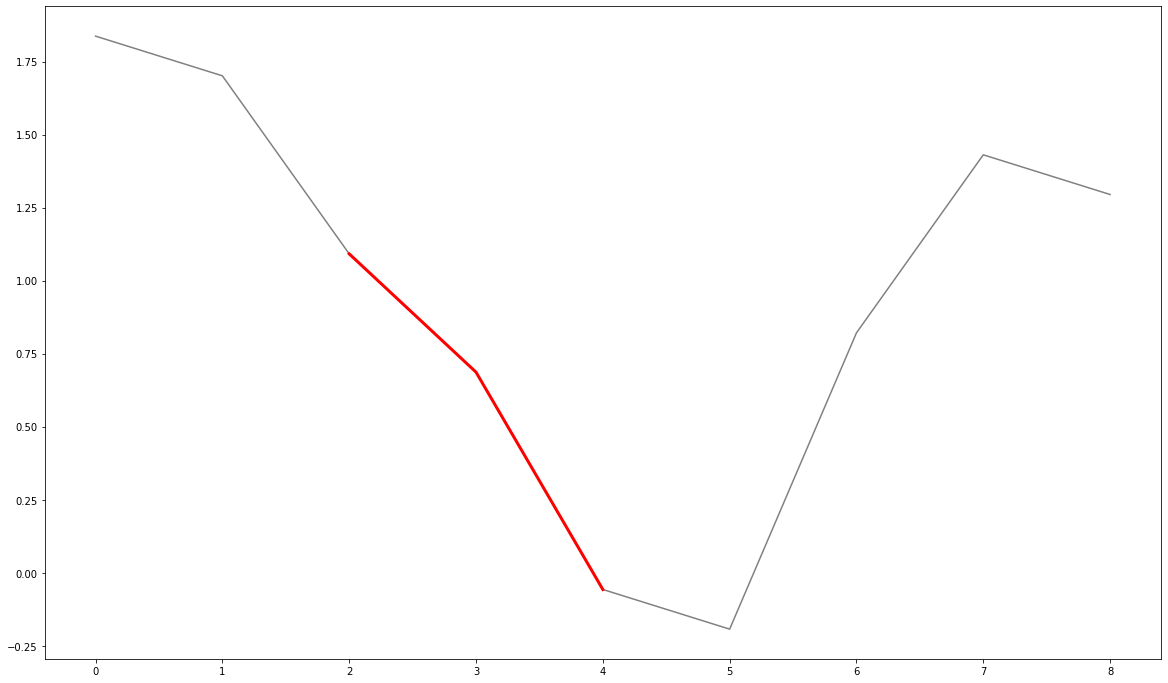

In [54]:
# for each extracted shapelet (in descending order of quality/information gain)
for s in st.shapelets:

    # summary info about the shapelet
    print(s)

    # plot the series that the shapelet was extracted from
    plt.plot(
        X[s.series_id],
        'gray'
    )

    # overlay the shapelet onto the full series
    plt.plot(
        list(range(s.start_pos,(s.start_pos+s.length))),
        X[s.series_id,s.start_pos:s.start_pos+s.length],
        'r',
        linewidth=3.0
    )
    plt.show()

l_pattern_dict :패턴의 길이와 해당 길이의 패턴의 수를 매칭시켜놓은 변수

In [ ]:
l_pattern=[]
for l in np.unique([len(x) for x in pattern_candidate]):
    l_pattern.append(len([x for x in pattern_candidate if len(x)==l]))

In [ ]:
l_pattern_dict=dict()
for i,l in enumerate(l_pattern):
    l_pattern_dict[str(np.unique([len(x) for x in pattern_candidate])[i])]=l

# clustering for pattern_candidate

1. 패턴의 길이를 fix하고 해당 length의 패턴만을 클러스터링

In [ ]:
pattern_len = 6
specific_len_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if len(x['pattern_idx']) ==pattern_len]

In [ ]:
pattern_candidate =  np.asarray([consecutive_pattern[idx]['pattern'] for idx in specific_len_pattern_idx])
len(pattern_candidate)

## pattern standardization

1. pattern 원본 그대로 사용
2. 평균0, 분산1 형태로 standardization
3. 각 패턴이 0~1 사이로 min,max normalization 

1,2,3 방법 혹은 어떤 방법으로 정규화 할지를 같이 정하면 될것 같습니다.
저는 우선 2번,3번 방법으로 진행해보았습

#1. pattern 원본 그대로 사용
normalized_pattern_candidate =l_pattern_candidate

#2. 평균0, 분산1 형태로 standardization
from sklearn.preprocessing import StandardScaler
normalized_pattern_candidate =StandardScaler().fit_transform(np.asarray(l_pattern_candidate))

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
normalized_pattern_candidate =TimeSeriesScalerMeanVariance().fit_transform(pattern_candidate)
normalized_pattern_candidate = normalized_pattern_candidate.squeeze()
normalized_pattern_candidate.shape

#3.각 패턴이 0~1 사이로 min,max normalization
normalized_pattern_candidate = (l_pattern_candidate.T - l_pattern_candidate.min(axis=1))/(l_pattern_candidate.max(axis=1)- l_pattern_candidate.min(axis=1))
normalized_pattern_candidate = normalized_pattern_candidate.T

## spectral clustering, gmm clustering,k-means,SOM

In [ ]:
from sklearn import mixture,cluster
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
#n_cluster : interger
#eigen_solver{None, ‘arpack’, ‘lobpcg’, or ‘amg’}
#affinity: ‘nearest_neighbors’‘rbf’
default_spectral = {'n_clusters':2,
                    'eigen_solver': 'arpack',
                    'affinity': "rbf"}

#covariance_type{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
default_gmm = {'n_clusters':2, 'covariance_type': 'full'}
default_kmeans = {'n_clusters':2,'verbose':False,'random_state':0}
default_hac = {'method':'single','metric':'euclidean','cut_off_level':5,'criterion':'maxclust'}

spectral_option = [
    ({'n_clusters': 6})
]

gmm_option = [
    ({'n_clusters': 6})
    
]

kmeans_option = [
    ({'n_clusters': 6})
    
]

hac_option =[
    ({'cut_off_level': 6})
    
]

parameter 조절하며 시각화

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

In [ ]:
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for g_option,k_option in zip(gmm_option,kmeans_option):

    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    

    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])

    g_pred = gmm.fit_predict(normalized_pattern_candidate)
    k_pred = kmeans.fit_predict(normalized_pattern_candidate)
    
    g_cluster_mean_pattern =[]
    k_cluster_mean_pattern =[]

    fig = plt.figure(figsize=(len(np.unique(g_pred))*3,7))
    axes = fig.subplots(2, g_params['n_clusters'])
    for class_ in range(0,g_params['n_clusters']):
        g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        k_class_idx = [i for i,x in enumerate(k_pred) if x ==class_]

        try:
            axes[1,class_].plot(normalized_pattern_candidate[random.sample(g_class_idx,30)].T, color =color[class_],alpha=0.6)
            axes[2,class_].plot(normalized_pattern_candidate[random.sample(k_class_idx,30)].T, color =color[class_],alpha=0.6)

        except:
            axes[0,class_].plot(normalized_pattern_candidate[g_class_idx].T, color =color[class_],alpha=0.6)
            axes[1,class_].plot(normalized_pattern_candidate[k_class_idx].T, color =color[class_],alpha=0.6)

        g_cluster_mean = normalized_pattern_candidate[g_class_idx].mean(axis=0)
        g_cluster_mean_pattern.append(g_cluster_mean)
        k_cluster_mean = normalized_pattern_candidate[k_class_idx].mean(axis=0)
        k_cluster_mean_pattern.append(k_cluster_mean)
        axes[0,class_].plot(normalized_pattern_candidate[g_class_idx].mean(axis=0), color ='black',alpha=1,linewidth=5)
        axes[1,class_].plot(normalized_pattern_candidate[k_class_idx].mean(axis=0), color ='black',alpha=1,linewidth=5)

    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()

In [ ]:
import more_itertools as mit
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==1]
#sample_data_idx = [i for i,x in enumerate(prediction) if np.argmax(x)==0]

In [ ]:
plot_idx = 0
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
for d_idx in sample_data_idx:
######## 특정 샘플의 패턴 리스트 생성  
    # sample_data_idx의 전체 패턴
    specific_data_pattern_idx=[i for i,x in enumerate(consecutive_pattern) if x['data_idx'] ==d_idx]
    specific_pattern_idx= list(set(specific_data_pattern_idx) & set(specific_len_pattern_idx))
    specific_pattern_info = [consecutive_pattern[x] for x in specific_pattern_idx]
    
    #해당 데이터에 미리 정한 길이만큼의 패턴이 없을 경우 pass
    if len(specific_pattern_info):
        pass
        
    # 총 10개의 plot을 그릴때까지 진행
    if plot_idx ==9:
        break
    
    print(len(specific_pattern_info))
    
    for p_channel in np.unique([(x['pattern_channel']) for x in specific_pattern_info if (x['data_idx']==d_idx)]):
        plot_idx+=1
        fig, ax= plt.subplots(figsize=(15,3))
        ax.set_xlim([0,int(trainX.shape[2])-1])
        spotlight = last_conv_bool[d_idx,:,p_channel]
        
        # 데이터 자체 그리기
        data = trainX[d_idx,0,:,input_channel]
        ax.plot(data,color='black')
        ax.set_facecolor("grey") # 패턴이 있는 부분만 흰색 spotlight으로 하기 위해 기본 배경을 회색으로 설정
            
        for spotlight_se in [(list(group)) for group in mit.consecutive_groups([i for i,x in enumerate(spotlight) if x==True])]:
            ax.axvspan(spotlight_se[0], spotlight_se[-1], color='white', alpha=1)
                
        for idx,pattern_x, pattern in [(i,x['pattern_idx'],x['pattern']) for i,x in enumerate(specific_pattern_info) if (x['data_idx']==d_idx  and x['pattern_channel']==p_channel)]:
            # 데이터의 해당 패턴 그리기
            pattern_idx = specific_pattern_idx[idx]
            color_idx = g_pred[specific_len_pattern_idx.index(pattern_idx)]
            pattern_x = consecutive_pattern[pattern_idx]['pattern_idx']
            #pattern = consecutive_pattern[pattern_idx]['pattern']
            ax.plot(pattern_x, data[pattern_x], color = color[color_idx])


            # 패턴의 평균값 굵고 투명하게 그리기
            x = g_cluster_mean_pattern[color_idx].reshape(-1,1) #returns a numpy array
            min_max_scaler = MinMaxScaler(feature_range=(data[pattern_x].min(), data[pattern_x].max()))
            x_scaled = min_max_scaler.fit_transform(x)
            ax.plot(pattern_x, x_scaled, color = color[color_idx], alpha=0.4,linewidth=10)
        fig.suptitle("prediction{}, data{}, output_channel{}".format(np.argmax(prediction[d_idx]),d_idx,p_info['pattern_channel']))
    plt.show()

# Below part is still unclear

## hierarchical clustering

In [ ]:
import math
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec

D = hac.linkage(normalized_pattern_candidate[:20], method='single',metric='euclidean')
cut_off_level = 5
#Dendrogram
plt.figure(figsize=(15, 5))
plt.title('Dendrogram of time series clustering',fontsize=25, fontweight='bold')
plt.xlabel('sample index', fontsize=25, fontweight='bold')
plt.ylabel('distance', fontsize=25, fontweight='bold')
hac.dendrogram(D, leaf_rotation=90., leaf_font_size=15., ) # font size for the x axis labels
plt.show()

특정 파라미터에 해당하는 클러스터 시각화

In [ ]:
import matplotlib.patheffects as pe

In [ ]:
random.seed(300)
sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),len(normalized_pattern_candidate))
color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]

In [ ]:
for s_option,g_option,k_option in zip(spectral_option[::-1],gmm_option[::-1],kmeans_option[::-1]):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    k_params = default_kmeans.copy()
    k_params.update(k_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    kmeans = cluster.KMeans(
        n_clusters=k_params['n_clusters'], 
        random_state=k_params['random_state'])
    
    spectral.fit(normalized_pattern_candidate)
    gmm.fit(normalized_pattern_candidate)
    kmeans.fit(normalized_pattern_candidate)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    k_pred = kmeans.fit_predict(normalized_pattern_candidate[sample_data_idx])
    
    num_class = len(list(set(np.unique(s_pred)).union(set(np.unique(g_pred)))))
    fig = plt.figure(figsize=(18,5))
    axes = fig.subplots(3,num_class)    
    
    for class_ in range(0,num_class):
        class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
        try:
            axes[0][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[0][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color = 'black',alpha=1,linewidth=3,
                   path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        
        class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
        try:
            axes[1][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[1][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
        class_idx = [i for i,x in enumerate(k_pred) if x ==class_]
        try:
            axes[2][class_+1].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].T, color =color[class_],alpha=0.6)
            axes[2][0].plot(normalized_pattern_candidate[[sample_data_idx[x] for x in class_idx]].mean(axis=0), color ='black',alpha=1,linewidth=3,
                    path_effects=[pe.Stroke(linewidth=10, foreground=color[class_]), pe.Normal()])
        except:
            pass
    #fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params),y=0.98)
    plt.tight_layout()
    break

# SOM

In [ ]:
import sompy

In [ ]:
som = sompy.SOMFactory.build(normalized_pattern_candidate, mapsize=None, normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose=False)  # verbose='debug' will print more, and verbose=None wont print anything

In [ ]:
from sompy.visualization.hitmap import HitMapView
som.cluster(4)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(som)

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=10)
view2D.show(som, col_sz=4, which_dim="all", desnormalize=True)

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

## represent as feature vector

### 1. wavelet

In [ ]:
import do_wavelet
import matplotlib.gridspec as gridspec
import pywt

In [ ]:
N = normalized_pattern_candidate[3].shape[0]
t0=10
dt=1
time = np.arange(0, N) * dt + t0
signal = normalized_pattern_candidate[3]
 
scales = np.arange(1, 128)

In [ ]:
fig = plt.figure(figsize=(12,6))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[:2, 0:5])
bottom_left_ax = fig.add_subplot(spec[2:, 0:5])
bottom_right_ax = fig.add_subplot(spec[2:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

### 2. clustering time series using unsupervised shapelets

In [291]:
D =pattern.copy(deep=True)
sLen = range(6,32)

S_hat={}
ts =D[500]

IndexError: list index out of range

In [293]:
len(pattern)

269

In [290]:


while True:
    cnt=0 #count of candidate u-shapelets from ts
    s_hat ={} #set of subsequences, initially empty
    gap = []
    dt =[]
    gap = []
    dt =[]
        
    for sl in sLen:#each u-shapelet length

        if len(ts)-sl==0:
            break
        for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
            s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
            tup = compute_gap(s_hat[cnt],D,6)
            gap.append(tup[0])
            dt.append(tup[1])
            cnt+=1
        try:
            print("try")
            index1 = np.argmax(gap)
            S_hat = s_hat[index1] #find maximum gap score
            dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score
            dA= [dis[i] for i,x in enumerate(dis<dt[index1]) if x==True]#points to the left of dt
            if len(dA) ==1:
                break
            else:
                print("else")
                index2 = np.argmax(dis)
                ts = D[index2]
                msdA= np.mean(dA) +np.std(dA)
                D_hat = [i for i,x in enumerate(dis<msdA) if x ==True]
                for d_hat in D_hat:
                    del D[d_hat]
                
        except:
            continue

IndexError: list index out of range

In [272]:
index2 = np.argmax(dis)

In [276]:
ts =D[index2]

In [282]:
msdA= np.mean(dA) +np.std(dA)

In [ ]:
D

In [285]:
[i for i,x in enumerate(dis<msdA) if x ==True]

[143,
 146,
 152,
 155,
 157,
 159,
 161,
 162,
 163,
 164,
 166,
 169,
 173,
 175,
 176,
 178,
 179,
 181,
 184,
 186,
 189,
 190,
 192,
 198,
 200,
 202,
 203,
 204,
 207,
 209,
 212,
 214,
 217,
 389,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 494,
 495,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 505,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 517,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 541,
 542,
 543,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 561,
 562,
 563,
 564,
 565,
 566,
 567,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 589,
 590,
 591,
 592,
 593,
 594,
 595,
 596,
 597,
 598,
 599,
 600,
 601,
 602,
 604,
 605,
 606,
 607,
 608,
 609,
 610,
 611,
 612,
 613,
 614,
 615,
 616,
 619,
 620,
 621,
 622,
 623,
 624]

In [245]:
sl = 6

In [257]:
s_hat ={} 
gap = []
dt =[]
cnt = 0
for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
    s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
    tup = compute_gap(s_hat[cnt],D,6)
    gap.append(tup[0])
    dt.append(tup[1])
    cnt+=1

In [258]:
sl=7
for i in np.arange(0, len(ts)-sl +1):#each subsequence from ts 
    s_hat[cnt] = ts[i:i+sl] #a subsequence of length sl
    tup = compute_gap(s_hat[cnt],D,6)
    gap.append(tup[0])
    dt.append(tup[1])
    cnt+=1

In [264]:
index1 = np.argmax(gap)
S_hat = s_hat[index1] #find maximum gap score
dis = compute_distance(s_hat[index1],D)#add the u-shapelet with max gap score

In [266]:
S_hat

[1.7010875980723468,
 1.0918366570277762,
 0.6869880879787071,
 -0.056772801088751546,
 -0.1926014740921644,
 0.8214980360014752,
 1.430748977046046]

In [278]:
print("try")
index1 = np.argmax(gap)
S_hat = s_hat[index1] #find maximum gap score
dis = compute_distance(S_hat,D)#add the u-shapelet with max gap score
dA= [dis[i] for i,x in enumerate(dis<dt[index1]) if x==True]#points to the left of dt

try


[4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 4.8074067159589095e-17,
 0.4078327421941607,
 0.4078327421941607,
 0.4078327421941607,
 0.4078327421941607,
 0.4078327421941607,
 0.18355631586570148,
 0.18355631586570148,
 0.18355631586570148,
 0.1

In [228]:
ts = D[0]

In [230]:
dA.mean()

3.865442050487204e-05

In [97]:
def znorm(data):
    return (data-min(data))/(max(data)-min(data))

In [88]:
def euclidean_d(data1,data2):
    return np.linalg.norm(data1-data2)

In [223]:
def compute_gap(sub, data,cluster_num):
    dis= compute_distance(sub,data)
    dis = np.sort(dis)
    maxGap = 0
    dt = 0
    for l in range(1, len(dis)-1):
        d = (dis[l]+dis[l+1])/2

        dA = dis[dis<d]
        dB = dis[dis>d]
        try:
            r = len(dA)/len(dB)
            if ((1/cluster_num < r) and (1-(1/cluster_num))):
                mA = dA.mean()
                mB = dB.mean()
                sA = dA.std()
                sB = dB.std()
                gap = mB-sB-(mA+sA)
                if gap > maxGap :
                    #print("gap {}".format(gap))
                    maxGap =gap
                    dt =d
        except:
            pass
    return maxGap, dt

In [152]:
dis=compute_distance(s_hat[0],D)

In [153]:
dis = np.sort(dis)

In [165]:
d=dis[130]

In [166]:
d

0.00823747376897096

In [167]:
dA =dis[dis<d]

In [168]:
dB =dis[dis>d]

In [169]:
r = len(dA)/len(dB)

In [177]:
mA = dA.mean()
mB = dB.mean()
sA = dA.std()
sB = dB.std()
gap = mB-sB-(mA+sA)

In [178]:
gap

4677.761229021197

In [133]:
def compute_distance(sub, data):
    dis=[10e3]*len(data)
    sub = znorm(sub)
    for i in range(0,len(data)):
        ts = data[i]

        for j in range(0, len(ts)-len(sub)):
            z = znorm(ts[j:j+len(sub)])
            d = euclidean_d(z,sub)
            dis[i]= min(d,dis[i])/np.sqrt(len(sub))
        #print(dis[i])
    return dis

In [134]:
dis =compute_distance(s_hat[0],D)

In [155]:
dis[0]

0.0

In [ ]:
s_option =spectral_option[-1]
g_option=gmm_option[-1]
s_params = default_spectral.copy()
s_params.update(s_option)

g_params = default_gmm.copy()
g_params.update(g_option)

spectral = cluster.SpectralClustering(
    n_clusters=s_params['n_clusters'], 
    eigen_solver=s_params['eigen_solver'],
    affinity=s_params['affinity'])

gmm =  mixture.GaussianMixture(
    n_components=g_params['n_clusters'], 
    covariance_type=g_params['covariance_type'])

s_pred = spectral.fit_predict(normalized_pattern_candidate)
g_pred = gmm.fit_predict(normalized_pattern_candidate)

s_representative_pattern =[]
g_representative_pattern =[]
for class_ in np.unique(s_pred):

    s_class_idx = [i for i,x in enumerate(s_pred) if x ==class_]
    s_representative_pattern.append(normalized_pattern_candidate[s_class_idx].mean(axis=0))

    g_class_idx = [i for i,x in enumerate(g_pred) if x ==class_]
    g_representative_pattern.append(normalized_pattern_candidate[g_class_idx].mean(axis=0))


In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 2, 1,projection='3d')

x = ((g_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((g_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((g_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax.scatter(x,y,z, c = g_pred)

ax.set_xlabel('class1')
ax.set_ylabel('class2')
ax.set_zlabel('class3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
#ax.axis('off')

ax2 = fig.add_subplot(1, 2, 2,projection='3d')

x = ((s_representative_pattern[0]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
y = ((s_representative_pattern[1]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)
z = ((s_representative_pattern[2]*len(normalized_pattern_candidate)-normalized_pattern_candidate)**2).sum(axis=1)

ax2.scatter(x,y,z, c = s_pred)

ax2.set_xlabel('class1')
ax2.set_ylabel('class2')
ax2.set_zlabel('class3')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

color = ["crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey",
        "crimson","orange","olive",'seagreen',"royalblue","purple","pink","grey"]
random.seed(300)
for s_option,g_option in zip(spectral_option,gmm_option):
    s_params = default_spectral.copy()
    s_params.update(s_option)
    
    g_params = default_gmm.copy()
    g_params.update(g_option)
    
    spectral = cluster.SpectralClustering(
        n_clusters=s_params['n_clusters'], 
        eigen_solver=s_params['eigen_solver'],
        affinity=s_params['affinity'])
    
    gmm =  mixture.GaussianMixture(
        n_components=g_params['n_clusters'], 
        covariance_type=g_params['covariance_type'])
    
    s_pred = spectral.fit(normalized_pattern_candidate)
    g_pred = gmm.fit(normalized_pattern_candidate)
    
    sample_data_idx = random.sample(range(0,len(normalized_pattern_candidate)),100)
    
    s_pred = spectral.labels_[sample_data_idx]
    g_pred = gmm.predict(normalized_pattern_candidate[sample_data_idx])
    
    fig = plt.figure(figsize=(15,3))
    for class_ in np.unique(s_pred):
        ax = plt.subplot(1,2,1)
        class_idx = [sample_data_idx[i] for i,x in enumerate(s_pred) if x ==class_]
        ax.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
        ax.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)

        ax2 = plt.subplot(1,2,2)
        class_idx = [sample_data_idx[i] for i,x in enumerate(g_pred) if x ==class_]
        try:
            #ax2.plot(normalized_pattern_candidate[class_idx].T, color =color[class_],alpha=0.2)
            ax2.plot(normalized_pattern_candidate[class_idx].mean(axis=0), color =color[class_],alpha=1,linewidth=5)
        except:
            continue

    fig.suptitle("Spectral Clustering: {} \nGMM: {}".format(s_params,g_params))
    plt.tight_layout()


### plotly visualization을 위해 샘플 데이터 및 패턴 저장

In [ ]:
sample_data_idx=87
sample_output_channel = 79
sample_data = pd.DataFrame(trainX[sample_data_idx].reshape(-1,9))

In [ ]:
sample_pattern_bool =pd.DataFrame(last_conv_bool[sample_data_idx][:,sample_output_channel])
pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx][:,sample_output_channel]) if x]

In [ ]:
last_conv_bool[sample_data_idx][:,sample_output_channel].sum()

In [ ]:
groups = []
for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
    groups.append(list(g))    # Store group iterator as a list

In [ ]:
consecutive_pattern=[]
for g in groups:
    if len(g)>consecutive_num:
        consecutive_pattern.extend(g)
        
consecutive_pattern_bool=[]
for x in range(0,128):
    if x in np.asarray(consecutive_pattern).flatten():
        consecutive_pattern_bool.append(True)
    else:
        consecutive_pattern_bool.append(False)

In [ ]:
sample_consecutive_pattern_bool= pd.DataFrame(consecutive_pattern_bool)

sample_data.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_data.csv')
sample_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_pattern.csv')
sample_consecutive_pattern_bool.to_csv('./sample_data+pattern/'+str(sample_data_idx)+'_consecutive_pattern.csv')

## 2d visualization

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

DEFAULT_PLOTLY_COLORS=['rgba(31, 119, 180, {})', 'rgba(255, 127, 14, {})',
                       'rgba(44, 160, 44, {})', 'rgba(214, 39, 40, {})',
                       'rgba(148, 103, 189, {})', 'rgba(140, 86, 75, {})',
                       'rgba(227, 119, 194, {})', 'rgba(127, 127, 127, {})',
                       'rgba(188, 189, 34, {})', 'rgba(23, 190, 207, {})']

normalized_data = (sample_data.values - sample_data.values.min(axis=0))/(sample_data.values.max(axis=0) - sample_data.values.min(axis=0))
for cidx in range(0,sample_data.shape[1]):
    normalized_data[:,cidx] =normalized_data[:,cidx] + cidx 
    
    
fig = make_subplots(
    rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.02
)

for cidx in range(sample_data.shape[-1]):
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0]), 
                             y=normalized_data[:,cidx],  
                            line_color="black",
                             line_width=1,
                             showlegend=False,
                             ),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=np.arange(sample_data.shape[0])[consecutive_pattern_bool], 
                            y=normalized_data[consecutive_pattern_bool,cidx],  
#                               fill='toself',
                            line_color='rgba(200, 0, 200, 0.6)',
                            line_width=5,
                            showlegend=False,
                            ),
                   row=1, col=1)
    
fig.update_xaxes(showline=True, linewidth=2, linecolor='black',ticks="inside")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black',
                 ticks="inside",nticks=sample_data.shape[1], tickwidth=2, tickcolor='black', ticklen=10,title_text='Input Channel',
                showgrid=True, gridwidth=1, gridcolor='grey',
                ticktext=["Channel1", "Channel2", "Channel3", "Channel4","Channel5", "Channel6", "Channel7", "Channel8", "Channel9"],
                tickvals=["1", "2", "3", "4", "5", "6","7", "8", "9"],
                range=[0,9])


fig.update_layout(height=600, width=800,plot_bgcolor='rgb(256,256,256)',
                  title_text="Input")

fig.show()

## 3d visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%matplotlib qt

In [ ]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink","cyan","orange","lime","pink","cyan"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred","dodgerblue","coral","seagreen","indianred","dodgerblue"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,1)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],1)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    for c in range(0,input_channel):
        data = trainX[sample_data_idx,:,:,c].reshape(-1,1)
        data = (data-data.min())/(data.max()-data.min())
        pattern_idx = [p for p, x in enumerate(last_conv_bool[sample_data_idx[0],:,c]) if x]
        #ax = fig.gca(projection='3d')

        ax.plot([c]*len(data),range(0,len(data)), data.flatten())
        # 패턴의 연속성을 찾는 구간
        groups = []
        for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
            groups.append(list(g))    # Store group iterator as a list
        for g in groups:
            if len(g)>consecutive_num:
                ax.scatter([c]*len(g) ,g,data[g],color = consecutive_class_color[c], s =12,alpha=0.7)
                #ax.add_collection3d(plt.fill_between(np.arange(g[0],g[-1]),data[g[0]:g[-1]],0), zs=1, zdir='y')
                #ax[j].text(g[0],0,len(g))
            #else:
                #ax.scatter(g,[c]*len(g), data[g],color = class_color[c],s=12)
                
        ax.set_xticks=[]
        ax.set_yticks=[]
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.8, 0.2, 1]))
    break